Tutorial taken from http://sujitpal.blogspot.co.uk/2014/08/topic-modeling-with-gensim-over-past.html

Modified for simpler text file based data set.

Requires downloading the nltk stop words set, only needs to be done once via python.

*import nltk*

*nltk.download("stopwords")*

Also requires wordcloud library for word cloud visualizations

*pip install wordcloud*

In [68]:
import logging
import os
import nltk
import gensim
from gensim.corpora.dictionary import Dictionary
from gensim import corpora
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os
import wordcloud
from wordcloud import WordCloud

%matplotlib inline

In [2]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Data and Pre-Processing

In [3]:
'''
def iter_docs(topdir, stoplist):
    for fn in os.listdir(topdir):
        fin = open(os.path.join(topdir, fn), 'rb')
        text = fin.read()
        fin.close()
        yield (x for x in 
            gensim.utils.tokenize(text, lowercase=True, deacc=True, 
                                  errors="ignore")
            if x not in stoplist)
'''

class MyCorpus(object):
    def __iter__(self):
        for line in open('../Data/tutorial_corpus.txt'):
            # assume there's one document per line, tokens separated by whitespace
            yield self.dictionary.doc2bow(line.lower().split())
            
    def make_dictionary(self, stoplist=False, minfreq = 1):
        # create dictionary
        self.dictionary = corpora.Dictionary(line.lower().split() for line in open('../Data/tutorial_corpus.txt'))

        if stoplist != False:
            # ids to remove stop words
            stop_ids = [self.dictionary.token2id[stopword] for stopword in stoplist
                        if stopword in self.dictionary.token2id]
        else:
            stop_ids = []
            
        # ids to remove words that appear 'minfreq' or fewer times.
        once_ids = [tokenid for tokenid, docfreq in self.dictionary.dfs.iteritems() if docfreq <= minfreq]
        
        # remove stop words and words that appear only once
        self.dictionary.filter_tokens(stop_ids + once_ids) 
        
        # remove gaps in id sequence after words that were removed
        self.dictionary.compactify() 
        
    '''
    def __init__(self, topdir, stoplist):
        self.topdir = topdir
        self.stoplist = stoplist
        self.dictionary = gensim.corpora.Dictionary(iter_docs(topdir, stoplist))
        
    def __iter__(self):
        for tokens in iter_docs(self.topdir, self.stoplist):
            yield self.dictionary.doc2bow(tokens)
    '''

In [4]:
# paths to relevant folders
#TEXTS_DIR = "/path/to/texts/dir"
MODELS_DIR = "saved_models/"

# stop list from nltk
stoplist = set(nltk.corpus.stopwords.words("english"))

# instantiate corpus object
#corpus = MyCorpus(TEXTS_DIR, stoplist)
corpus = MyCorpus() # memory friendly corpus!

In [5]:
# create dictionary, remove stopwords and words only occurring once
corpus.make_dictionary(stoplist=stoplist,minfreq=1) 

# save the dictionary
corpus.dictionary.save(MODELS_DIR + "mtsamples.dict")

# save the corpus
gensim.corpora.MmCorpus.serialize(MODELS_DIR + "mtsamples.mm", corpus)

## 2D Feature Projection

In [6]:
MODELS_DIR = "saved_models/"

# load the dictionary
dictionary = gensim.corpora.Dictionary.load(os.path.join(MODELS_DIR, 
                                            "mtsamples.dict"))

# load the corpus
corpus = gensim.corpora.MmCorpus(os.path.join(MODELS_DIR, "mtsamples.mm"))


tfidf = gensim.models.TfidfModel(corpus, normalize=True)
corpus_tfidf = tfidf[corpus]

# project to 2 dimensions for visualization
lsi = gensim.models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2)

# write out coordinates to file
fcoords = open(os.path.join(MODELS_DIR, "coords.csv"), 'wb')
for vector in lsi[corpus]:
    if len(vector) != 2:
        continue
    fcoords.write("%6.4f\t%6.4f\n" % (vector[0][1], vector[1][1]))
fcoords.close()

## Visualizing

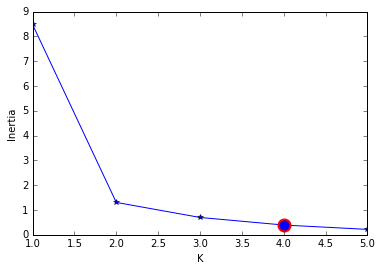

In [7]:
MAX_K = 5

X = np.loadtxt(os.path.join(MODELS_DIR, "coords.csv"), delimiter="\t")
ks = range(1, MAX_K + 1)

inertias = np.zeros(MAX_K)
diff = np.zeros(MAX_K)
diff2 = np.zeros(MAX_K)
diff3 = np.zeros(MAX_K)
for k in ks:
    kmeans = KMeans(k).fit(X)
    inertias[k - 1] = kmeans.inertia_
    # first difference    
    if k > 1:
        diff[k - 1] = inertias[k - 1] - inertias[k - 2]
    # second difference
    if k > 2:
        diff2[k - 1] = diff[k - 1] - diff[k - 2]
    # third difference
    if k > 3:
        diff3[k - 1] = diff2[k - 1] - diff2[k - 2]

elbow = np.argmin(diff3[3:]) + 3

plt.plot(ks, inertias, "b*-")
plt.plot(ks[elbow], inertias[elbow], marker='o', markersize=12,
         markeredgewidth=2, markeredgecolor='r', markerfacecolor=None)
plt.ylabel("Inertia")
plt.xlabel("K")
plt.show()

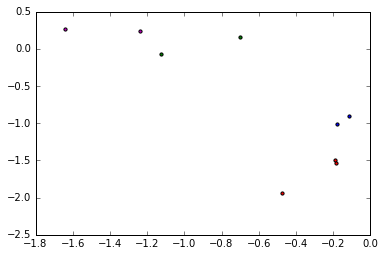

In [8]:
# Source: viz_topics_scatter.py
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

MODELS_DIR = "saved_models/"
NUM_TOPICS = 4

X = np.loadtxt(os.path.join(MODELS_DIR, "coords.csv"), delimiter="\t")
kmeans = KMeans(NUM_TOPICS).fit(X)
y = kmeans.labels_

colors = ["b", "g", "r", "m", "c"]
for i in range(X.shape[0]):
    plt.scatter(X[i][0], X[i][1], c=colors[y[i]], s=10)    
plt.show()

In [42]:
NUM_TOPICS = 4

dictionary = gensim.corpora.Dictionary.load(os.path.join(MODELS_DIR, 
                                            "mtsamples.dict"))

corpus = gensim.corpora.MmCorpus(os.path.join(MODELS_DIR, "mtsamples.mm"))

# Project to LDA space
lda = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=NUM_TOPICS)
print lda.print_topics(NUM_TOPICS)
f = open(MODELS_DIR+"final_topics.txt", 'w')
print >> f, lda.show_topics(NUM_TOPICS)
f.close()

[(0, u'0.225*system + 0.217*trees + 0.126*human + 0.125*eps + 0.123*graph + 0.027*minors + 0.026*user + 0.026*interface + 0.026*response + 0.026*time'), (1, u'0.138*system + 0.137*response + 0.137*user + 0.137*survey + 0.137*computer + 0.137*time + 0.032*trees + 0.030*graph + 0.029*minors + 0.029*eps'), (2, u'0.187*graph + 0.185*minors + 0.106*trees + 0.104*computer + 0.104*survey + 0.103*human + 0.103*interface + 0.022*system + 0.022*time + 0.022*user'), (3, u'0.222*user + 0.125*interface + 0.124*system + 0.123*eps + 0.123*response + 0.123*time + 0.029*trees + 0.027*graph + 0.026*minors + 0.026*human')]


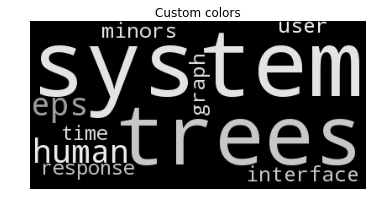

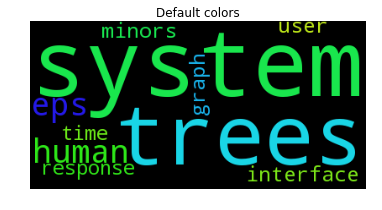

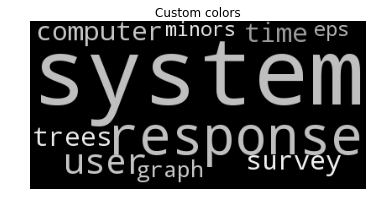

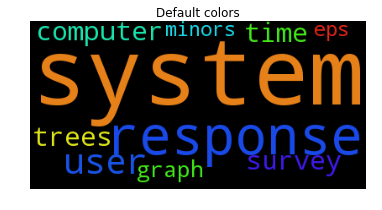

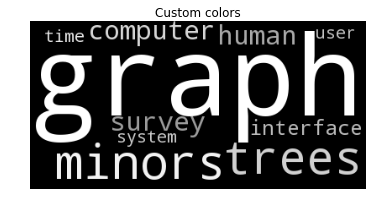

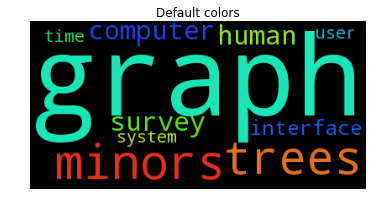

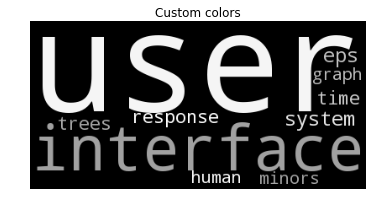

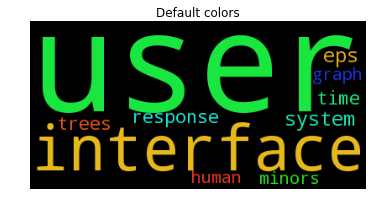

In [76]:
import random
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

final_topics = open(os.path.join(MODELS_DIR, "final_topics.txt"), 'rb')

lines = final_topics.readlines()[0].strip("[()").strip("]\n").split("(")
lines = [i.strip("),").split(", u'")[1] for i in lines]
for line in lines:
    scores = [float(x.split("*")[0]) for x in line.split(" + ")]
    words = [x.split("*")[1].strip("'), ") for x in line.split(" + ")]

    freqs = []
    for word, score in zip(words, scores):
        freqs.append((word, score))
    
    wc = WordCloud(max_words=50)
    elements = wc.fit_words(freqs)
    #wc.draw(elements, "gs_topic_%d.png" % (curr_topic),
    #               width=120, height=120)
    # store default colored image
    default_colors = wc.to_array()
    plt.title("Custom colors")
    plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3))
    wc.to_file("a_new_hope.png")
    plt.axis("off")
    plt.figure()
    plt.title("Default colors")
    plt.imshow(default_colors)
    plt.axis("off")
    plt.show()
    
    curr_topic += 1
final_topics.close()

["0.225*system + 0.217*trees + 0.126*human + 0.125*eps + 0.123*graph + 0.027*minors + 0.026*user + 0.026*interface + 0.026*response + 0.026*time'), ",
 "0.138*system + 0.137*response + 0.137*user + 0.137*survey + 0.137*computer + 0.137*time + 0.032*trees + 0.030*graph + 0.029*minors + 0.029*eps'), ",
 "0.187*graph + 0.185*minors + 0.106*trees + 0.104*computer + 0.104*survey + 0.103*human + 0.103*interface + 0.022*system + 0.022*time + 0.022*user'), ",
 "0.222*user + 0.125*interface + 0.124*system + 0.123*eps + 0.123*response + 0.123*time + 0.029*trees + 0.027*graph + 0.026*minors + 0.026*human'"]

In [65]:
print wordcloud.WordCloud.__dict__.keys()

['generate_from_text', '__module__', '_check_generated', 'to_image', '__array__', 'fit_words', 'process_text', 'to_html', '__doc__', 'recolor', '__init__', '__dict__', 'to_array', 'to_file', '__weakref__', 'generate', 'generate_from_frequencies']
